# Predict pay user
本文使用中间数据集的特征预测7日后付费的用户（包括复购和新付费用户）。

通过对5大类因子有效性的研究得到有效的模型输入. 筛选因子的主要方法：
1. 大类中的因子等权平均
2. 大类中的因子用PCA压缩（矩阵正交），得到最大解释比例的因子
3. stepwise(RFE)，通过ploy, cross product产生的新因子，使用模型迭代筛选出最有效的因子

[Strategies to scale computationally: bigger data](http://scikit-learn.org/stable/modules/scaling_strategies.html)

In [1]:
# improt packages
import pandas as pd
import pprint
import tableprint as tp
import numpy as np
import itertools as it

import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

font0 = FontProperties()
alignment = {'horizontalalignment': 'center', 'verticalalignment': 'baseline'}
# Show family options

families = ['serif', 'sans-serif', 'cursive', 'fantasy', 'monospace']

font1 = font0.copy()
font1.set_size('large')
plt.style.use('ggplot')
pp = pprint.PrettyPrinter(indent=4)
%matplotlib inline

读取X和y，均为未标准化数据集, y为log后的数据

In [2]:
X = pd.read_csv('tmp/X.csv',memory_map=True)
X=X.fillna(0)

In [3]:
valid_cols = list(map(lambda x: not x.startswith('prediction_'),X.columns))
X=X.loc[:,valid_cols]
X.shape

(2288007, 53)

In [4]:
y = pd.read_csv('tmp/y.csv',header=None)
y_clf = y.values.ravel()>0

In [5]:
y_log = np.log(y.values.ravel()+1)
y.shape

(2288007, 1)

In [6]:
df_variable = pd.read_excel('data/tap4fun.xlsx',sheet_name='Sheet1')
df_variable = df_variable.iloc[:,range(3)].rename(columns={'字段名':'column','字段解释':'desc','数据时间':'cycle'})
df_variable['cat'] = df_variable.column.str.split('_').apply(lambda x: x[0])


将因子做成n类，分别做因子合成
- 支付/消费： 订单总和，订单量总和，平均订单价值
- 会员活跃度： 在线时间
- 游戏效率：战争积分，内政积分, 
- 异动指标：周平均流失率，日平均流失率
- 转化率：每小时消费金额， 每小时内政积分，第小时战争积分

对支付类因子做因子合成

In [7]:
# 查询消费类因子
from toolz import filter
pay_cols= list(filter(lambda x: 'pay' in x, X.columns))
pay_cols

['pay_price_log',
 'avg_pay',
 'pay_price_per_hour',
 'pay_count',
 'pay_price_group_(-0.01, 0.0]',
 'pay_price_group_(0.0, 1.0]',
 'pay_price_group_(1.0, 10.0]',
 'pay_price_group_(10.0, 100.0]',
 'pay_price_group_(100.0, 1000.0]',
 'pay_price_group_(1000.0, 5000.0]',
 'pay_price_group_(5000.0, 10000.0]',
 'avg_pay_group_(-0.01, 0.0]',
 'avg_pay_group_(0.0, 1.0]',
 'avg_pay_group_(1.0, 5.0]',
 'avg_pay_group_(5.0, 10.0]',
 'avg_pay_group_(10.0, 20.0]',
 'avg_pay_group_(20.0, 50.0]',
 'avg_pay_group_(50.0, 100.0]',
 'pay_count_group_(-1, 0]',
 'pay_count_group_(0, 1]',
 'pay_count_group_(1, 2]',
 'pay_count_group_(2, 3]',
 'pay_count_group_(3, 4]',
 'pay_count_group_(4, 200]']

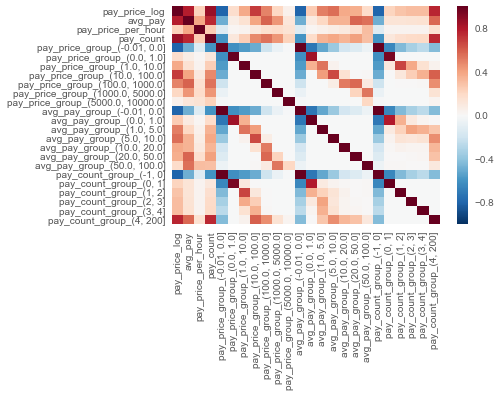

In [8]:
pay_corr = X.loc[:,pay_cols].corr()
sns.heatmap(pay_corr);

In [11]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit( X.loc[:,pay_cols])


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:
np.cumsum(pca.explained_variance_ratio_)

array([0.84119659, 0.94302524, 0.97623468, 0.98737931, 0.99240494,
       0.99487397, 0.9960829 , 0.99722461, 0.99805445, 0.99884476,
       0.99937326, 0.99967542, 0.99982154, 0.99990903, 0.99996146,
       0.99998096, 0.99999045, 0.99999863, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

会员活跃度因子

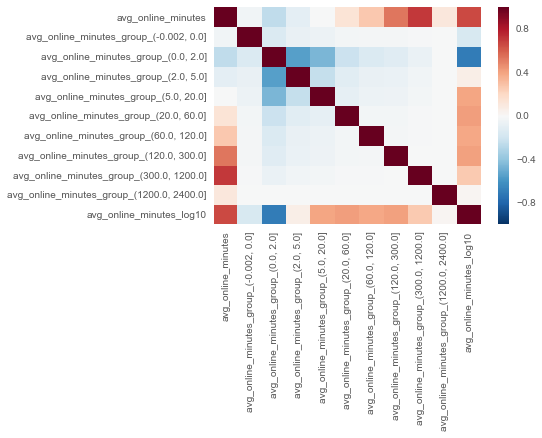

In [13]:
X['avg_online_minutes_log10'] = np.log10(X['avg_online_minutes']+1)

active_cols= list(filter(lambda x: 'avg_online' in x, X.columns)) 
active_corr = X.loc[:,active_cols].corr()
sns.heatmap(active_corr);

In [14]:
active_cols = ['avg_online_minutes_log10']#[x for x in active_cols  if x not in ['avg_online_minutes']]
active_cols

['avg_online_minutes_log10']

会员成就因子合成

In [15]:
X['acceleration_reduce%'].describe()

count    2.288007e+06
mean     1.797366e-01
std      1.092318e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.727273e-01
max      6.530000e+02
Name: acceleration_reduce%, dtype: float64

In [16]:
efficiency_cols = ['army_add','resource_add','acceleration_add']
for col in efficiency_cols:
    X[col+'_log'] = np.log(X[col]+1)

X['achievement'] = np.log(X['army_add']+X['resource_add']+1)
X['achievement_per_hour'] = X['achievement']/X['avg_online_minutes']/60
X['acceleration_per_hour'] = X['acceleration_add']/X['avg_online_minutes']/60    
X.loc[X.avg_online_minutes==0,'achievement_per_hour']=0
X.loc[X.avg_online_minutes==0,'acceleration_per_hour']=0
X['acceleration_per_hour_log']= np.log(X['acceleration_per_hour']+1)
X['acceleration_reduce_per_hour_log']= np.log(X['acceleration_per_hour']*X['acceleration_reduce%']+1)
X['resource_reduce_log']= np.log(X['resource_add']*X['resource_reduce%']+1)
X['army_reduce_log']= np.log(X['army_add']*X['resource_reduce%']+1)
X['achievement_per_hour_log']= np.log(X['achievement_per_hour']+1)
X['sr_main_score_per_hour_log']= np.log(X['sr_main_score']/X['avg_online_minutes']/60  +1)
X['sr_level_score_per_hour']= X['sr_level_score']/X['avg_online_minutes']/60
X['army_reduce_per_battle'] = (X['army_add']*X['army_reduce%']+1)/X['battle_count']
X.loc[X.avg_online_minutes==0,'sr_main_score_per_hour_log']=0
X.loc[X.avg_online_minutes==0,'sr_level_score_per_hour']=0
X.loc[X.battle_count==0,'army_reduce_per_battle']=0
X['sr_level_score_per_hour_log']= np.log(X['sr_level_score_per_hour'] +1)
X['bd_resource_ratio'] = X['resource_reduce%']*X['resource_add']/X['bd_main_score']
X.loc[X.bd_main_score==0,'bd_resource_ratio']=0
X['army_reduce_per_battle_log']= np.log(X['army_reduce_per_battle'] +1)
X['minutes_per_battle'] = X['avg_online_minutes']/X['battle_count']
X.loc[X.battle_count==0,'minutes_per_battle']=0
X = X.fillna(0)
# 'sr_level_score',
#  'sr_main_score',
#  'bd_main_score',
war_cols = ['battle_count','army_reduce_per_battle_log','minutes_per_battle','bd_resource_ratio','battle_win%','pvp_launch%','pvp_win%']
achievement_cols= ['sr_main_score','bd_main_score']#'resource_reduce_log','achievement','achievement_per_hour_log','acceleration_per_hour_log','acceleration_reduce_per_hour_log']
achievement_cols += war_cols
# achievement_corr = X.loc[:,achievement_cols].corr()
# sns.heatmap(achievement_corr);

In [17]:
X.loc[:,achievement_cols].describe()

,sr_main_score,bd_main_score,battle_count,army_reduce_per_battle_log,minutes_per_battle,bd_resource_ratio,battle_win%,pvp_launch%,pvp_win%
count,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06
mean,3.784112e-02,8.971792e-01,4.993052e+00,7.927039e-01,9.870452e-01,2.221769e+05,2.647617e-01,6.899958e-02,6.822605e-02
std,1.352270e-01,1.475248e+00,2.106555e+01,1.589268e+00,3.924223e+00,2.122022e+06,4.036848e-01,2.193975e-01,2.163774e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,3.125000e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.816000e+04,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.062500e+00,2.000000e+00,6.931472e-01,1.333333e+00,1.595880e+05,6.000000e-01,0.000000e+00,0.000000e+00
max,8.343750e+00,1.687500e+01,2.056000e+03,1.118569e+01,9.678333e+02,1.576357e+09,1.000000e+00,1.000000e+00,1.000000e+00


In [19]:
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from os import cpu_count
X_data = X.loc[:,achievement_cols]
lsvc = LassoCV(n_jobs = cpu_count(),fit_intercept=True,normalize=True).fit(X_data, y_log)

model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_data)
X_new.shape

(2288007, 3)

In [20]:
print('r2:%f'% lsvc.score(X_data, y_log))
lsvc.coef_

r2:0.254971


array([ 1.02828514e+00, -4.74832188e-03,  0.00000000e+00, -7.77318740e-03,
        0.00000000e+00,  1.29754448e-08, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00])

In [27]:
# achievement_cols= ['sr_main_score','army_reduce_per_battle_log','bd_resource_ratio','pvp_launch%']
achievement_cols=list(X_data.columns[lsvc.coef_!=0])

特征合成: 集成

In [28]:
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler

others_col = list(filter(lambda x: x not in pay_cols+active_cols,X.columns))
mapper_tp = DataFrameMapper([
    (pay_cols, PCA(n_components=10),{'alias':'pay_pca_'}),
    ]+list(map(lambda x: (x, None),active_cols+achievement_cols))
    , df_out=True)

X_transform = mapper_tp.fit_transform(X)

划分训练测试集

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_clf, test_size=.2,stratify =y_clf)

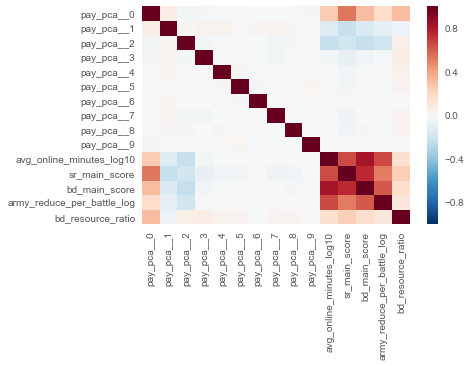

In [30]:
corr = X_test.corr()
sns.heatmap(corr);

使用随机森林预测7日后是否付费

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_X = MinMaxScaler()


In [32]:
%%time
from os import cpu_count
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(verbose=True, n_jobs=cpu_count(), 
                             class_weight={False:1, True:3}, min_samples_leaf = 2,
                             n_estimators=10, max_depth =8)

pipeline_clf = make_pipeline(scaler_X, clf)

pipeline_clf.fit(X_train, y_train)


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    5.1s remaining:    3.4s


Wall time: 10.2 s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    7.9s finished


test feature importance 特征重要度

In [34]:
var_importance = pipeline_clf.steps[1][1].feature_importances_
df_variable_importance =pd.DataFrame({'column':X_train.columns, 'importance':var_importance})
df_variable_importance = pd.merge(df_variable_importance,df_variable,on='column',how='left')
sel_vars = df_variable_importance[df_variable_importance.importance>0.001].sort_values('importance', ascending = False).column
df_variable_importance[df_variable_importance.column.isin(sel_vars)].sort_values('importance', ascending = False)

,column,importance,desc,cycle,cat
14,bd_resource_ratio,0.223870,NaN,NaN,NaN
3,pay_pca__3,0.189148,NaN,NaN,NaN
0,pay_pca__0,0.142857,NaN,NaN,NaN
2,pay_pca__2,0.100064,NaN,NaN,NaN
12,bd_main_score,0.090813,NaN,NaN,NaN
11,sr_main_score,0.052656,NaN,NaN,NaN
10,avg_online_minutes_log10,0.050418,NaN,NaN,NaN
5,pay_pca__5,0.050336,NaN,NaN,NaN
7,pay_pca__7,0.038647,NaN,NaN,NaN
1,pay_pca__1,0.019876,NaN,NaN,NaN


evaluate model using MAE

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, precision_recall_curve, confusion_matrix

data = {'train':[X_train, y_train],'test':[X_test,y_test]}
y_stacked = {'train':{},'test':{}}

for stage in data.keys():
    X_in, y_in = data.get(stage)
    y_predict = pipeline_clf.predict(X_in)
    f1 = f1_score(y_predict, y_in)
    accuracy = accuracy_score(y_predict, y_in)
    precision= precision_score(y_predict, y_in)
    recall = recall_score(y_predict, y_in)
#     print(f"{stage}: f1={f1},accuracy={accuracy},recall={recall}")
    print("{0}: f1={1},accuracy={2},precision={3},recall={4}".format(stage, f1,accuracy,precision,recall))
    y_stacked[stage]['random_forest']=y_predict
confusion_matrix(y_predict, y_in)

In [36]:
X.loc[:,sel_vars[:5]].corr()

,bd_resource_ratio,pay_pca__3,pay_pca__0,pay_pca__2,bd_main_score
bd_resource_ratio,1.00000,NaN,NaN,NaN,0.23806
pay_pca__3,NaN,NaN,NaN,NaN,NaN
pay_pca__0,NaN,NaN,NaN,NaN,NaN
pay_pca__2,NaN,NaN,NaN,NaN,NaN
bd_main_score,0.23806,NaN,NaN,NaN,1.00000


Apply Light GBM on predict future pay

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_log, test_size=.2,stratify =y_clf)

In [52]:
%%time
import lightgbm as lgb 


train_data=lgb.Dataset(X_train.loc[:,sel_vars],label=y_train)
param = {'num_leaves':150, 'objective':'regression','max_depth':7,'learning_rate':.1,'max_bin':200}
param['metric'] = ['l1']
num_round=50

lgbm=lgb.train(param,train_data,num_round)


Wall time: 3.74 s


In [53]:
%%time
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils.multiclass  import type_of_target

data = {'train':[X_train, y_train],'test':[X_test,y_test]}

for stage in data.keys():
    X_in, y_in = data.get(stage)
    y_predict = lgbm.predict(X_in.loc[:,sel_vars])

    mae = mean_absolute_error(y_in,y_predict)
    r2 = r2_score(y_in,y_predict)
    print("{0}: r2={1},mae={2}".format(stage, r2,mae))

test: r2=0.4682962086913416,mae=0.024491936476181128
train: r2=0.537954142903466,mae=0.023053987179477126
Wall time: 2.87 s


In [663]:
%%time
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.utils.multiclass  import type_of_target

data = {'train':[X_train, y_train],'test':[X_test,y_test]}

for stage in data.keys():
    X_in, y_in = data.get(stage)
    y_predict = lgbm.predict(X_in.loc[:,sel_vars])
    if type_of_target(y_predict)=="continuous":
        y_predict = y_predict>=.3
    f1 = f1_score(y_predict, y_in)
    accuracy = accuracy_score(y_predict, y_in)
    recall = recall_score(y_predict, y_in)
#     print(f"{stage}: f1={f1},accuracy={accuracy},recall={recall}")
    print("{0}: f1={1},accuracy={2},recall={3}".format(stage, f1,accuracy,recall))

test: f1=0.5073223648526487,accuracy=0.9940450435094252,recall=0.5947435353963544
train: f1=0.5343884241465069,accuracy=0.994374469038273,recall=0.6266836355923215
Wall time: 4.27 s


Tensorflow ADAM

In [281]:
%%time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras import backend as K

def auc(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)    
    return FP/N
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)    
    return TP/P

def make_model():
    model = Sequential([
        Dense(16, input_shape=(len(sel_vars),)),
        Activation('relu'),
        Dense(8),
        Activation('relu'),
        Dense(1),
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer='Adadelta',
                  metrics=[auc])

    return model
pipeline_classfier = make_pipeline(scaler_X,KerasClassifier(build_fn = make_model, batch_size=200000, class_weight={False:1,True:50}))
pipeline_classfier.fit(X_train.loc[:,sel_vars],y_train)

Epoch 1/10
1601604/1601604 [==============================] - 28s - loss: 1.2658 - auc: 0.5905    
Epoch 2/10
1601604/1601604 [==============================] - 4s - loss: 0.6980 - auc: 0.8183     
Epoch 3/10
1601604/1601604 [==============================] - 3s - loss: 0.6669 - auc: 0.9046     
Epoch 4/10
1601604/1601604 [==============================] - 3s - loss: 0.6384 - auc: 0.9319     
Epoch 5/10
1601604/1601604 [==============================] - 3s - loss: 0.6101 - auc: 0.9434     
Epoch 6/10
1601604/1601604 [==============================] - 3s - loss: 0.5828 - auc: 0.9500     
Epoch 7/10
1601604/1601604 [==============================] - 3s - loss: 0.5544 - auc: 0.9538     
Epoch 8/10
1601604/1601604 [==============================] - 4s - loss: 0.5249 - auc: 0.9561     
Epoch 9/10
1601604/1601604 [==============================] - 4s - loss: 0.4967 - auc: 0.9578     
Epoch 10/10
1601604/1601604 [==============================] - 4s - loss: 0.4692 - auc: 0.9588     
Wall time

In [282]:
%%time
from sklearn.metrics import f1_score, accuracy_score, recall_score

data = {'train':[X_train, y_train],'test':[X_test,y_test]}


for stage in data.keys():
    X_in, y_in = data.get(stage)
    y_predict = pipeline_classfier.predict(X_in.loc[:,sel_vars])
    f1 = f1_score(y_predict, y_in)
    accuracy = accuracy_score(y_predict, y_in)
    precision= precision_score(y_predict, y_in)
    recall = recall_score(y_predict, y_in)
#     print(f"{stage}: f1={f1},accuracy={accuracy},recall={recall}")
    print("{0}: f1={1},accuracy={2},precision={3},recall={4}".format(stage, f1,accuracy,precision,recall))
print(confusion_matrix(y_predict, y_in))

686403/686403 [==============================] - 15s    
test: f1=0.30271145285309586,accuracy=0.9924694385076989,precision=0.23907948007670998,recall=0.4125
1600000/1601604 [============================>.] - ETA: 0strain: f1=0.30621411109215985,accuracy=0.992380763284807,precision=0.2412001791312136,recall=0.41920921544209216
[[1586708    8472]
 [   3731    2693]]
Wall time: 20.1 s


optimize hyper parameter

In [188]:

# define an objective function
def objective(args):
    case, val = args
    if case == 'case 1':
        return val
    else:
        return val ** 2

# define a search space
from hyperopt import hp
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

print(best)
# -> {'a': 1, 'c2': 0.01420615366247227}
print(hyperopt.space_eval(space, best))
# -> ('case 2', 0.01420615366247227}

ImportError: No module named 'hyperopt'